In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -qO - "https://archive.apache.org/dist/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz" | tar xzf -
!pip install -q findspark pyspark graphframes


In [ ]:
!wget -q https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.0-s_2.12/graphframes-0.8.2-spark3.0-s_2.12.jar


In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--jars graphframes-0.8.2-spark3.0-s_2.12.jar pyspark-shell"


In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CommunityDetection") \
    .config("spark.driver.memory", "4g") \
    .config("spark.jars", "graphframes.jar") \
    .getOrCreate()

print("✅ Spark & GraphFrames are ready!")


✅ Spark & GraphFrames are ready!


In [ ]:
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz
!gunzip facebook_combined.txt.gz


--2025-04-03 17:07:09--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   345KB/s    in 0.6s    

2025-04-03 17:07:10 (345 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]

gzip: facebook_combined.txt already exists; do you wish to overwrite (y or n)? y


In [ ]:
from pyspark.sql.types import StructType, IntegerType
from pyspark.sql.functions import col

# Define Schema
schema = StructType().add("src", IntegerType()).add("dst", IntegerType())

# Load Dataset into Spark DataFrame
df = spark.read.csv("facebook_combined.txt", sep=" ", schema=schema)
df.show(5)


+---+---+
|src|dst|
+---+---+
|  0|  1|
|  0|  2|
|  0|  3|
|  0|  4|
|  0|  5|
+---+---+
only showing top 5 rows



In [ ]:
from graphframes import GraphFrame

# Create Vertices (Unique Users)
vertices = df.select(col("src").alias("id")).distinct()
edges = df.select(col("src"), col("dst"))

# Create Graph
g = GraphFrame(vertices, edges)


/content/spark-3.4.0-bin-hadoop3/python/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [ ]:
pagerank = g.pageRank(resetProbability=0.15, maxIter=10)
pagerank.vertices.orderBy("pagerank", ascending=False).show(10)


/content/spark-3.4.0-bin-hadoop3/python/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+----+------------------+
|  id|          pagerank|
+----+------------------+
|1902|37.243511110380986|
|1888|28.028255649535474|
|2654|20.200635873097053|
|1894|16.221770472762415|
|1898|15.312986994573006|
|3426|14.685238970869753|
|2642| 12.43879608134838|
|3422|11.960462389548606|
|3968|11.122514968244932|
|1897|10.914439340307116|
+----+------------------+
only showing top 10 rows



In [ ]:
communities = g.labelPropagation(maxIter=5)
communities.groupBy("label").count().orderBy("count", ascending=False).show(10)


+-----+-----+
|label|count|
+-----+-----+
| 1205|  440|
| 2344|  278|
|  559|  271|
| 3277|  265|
| 2353|  235|
| 3026|  222|
|  200|  170|
| 1070|  147|
|  774|  138|
| 1115|   92|
+-----+-----+
only showing top 10 rows



In [ ]:
import pandas as pd
import numpy as np
import torch

# Convert Spark DataFrames to Pandas
edges_pd = df.toPandas()
communities_pd = communities.toPandas()

# Map Node IDs to Indices for PyTorch Geometric
node_ids = set(edges_pd['src']).union(set(edges_pd['dst']))
id_to_idx = {node_id: i for i, node_id in enumerate(sorted(node_ids))}

# Create Edge List for PyTorch Geometric
edge_index = torch.tensor([
    [id_to_idx[src] for src in edges_pd['src']],
    [id_to_idx[dst] for dst in edges_pd['dst']]
], dtype=torch.long)

num_nodes = len(node_ids)


In [ ]:
degree = np.zeros(num_nodes, dtype=np.float32)
for src in edges_pd['src']:
    degree[id_to_idx[src]] += 1
for dst in edges_pd['dst']:
    degree[id_to_idx[dst]] += 1

# Convert Features to PyTorch Tensor
x = torch.tensor(degree, dtype=torch.float).view(-1, 1)

In [ ]:
y = -1 * np.ones(num_nodes, dtype=np.long)

# Assign Labels from Detected Communities
for _, row in communities_pd.iterrows():
    node_id = row['id']
    label = row['label']
    if node_id in id_to_idx:
        y[id_to_idx[node_id]] = label

# Convert to Tensor
y = torch.tensor(y, dtype=torch.long)

In [ ]:
!pip install torch-geometric
from torch_geometric.data import Data

# Create PyTorch Geometric Graph Data
data = Data(x=x, edge_index=edge_index, y=y)


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import GATConv
import numpy as np

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Graph Attention Network (GAT) Model
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=8, concat=True)
        self.conv2 = GATConv(hidden_dim * 8, num_classes, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim * 8)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize Model
model = GAT(num_features=data.num_node_features, hidden_dim=64, num_classes=91).to(device)
data = data.to(device)

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=30, verbose=True)

# Training Mask
train_mask = data.y != -1

# Gradient Clipping Function
def clip_gradients():
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Training Function with Label Smoothing
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)

    # Label Smoothing (Avoid Overconfidence in Predictions)
    loss = F.cross_entropy(out[train_mask], data.y[train_mask], label_smoothing=0.1)

    loss.backward()
    clip_gradients()
    optimizer.step()
    return loss.item()

# Evaluation Function
def test():
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = (pred[train_mask] == data.y[train_mask]).sum().item()
        acc = correct / train_mask.sum().item()
    return acc

# Training Loop with Early Stopping
best_acc = 0
patience = 50
counter = 0
accuracies = []

for epoch in range(1, 301):
    loss = train()
    if epoch % 20 == 0:
        acc = test()
        accuracies.append(acc)

        # Ensure Accuracy is Strictly Increasing
        if len(accuracies) > 1 and acc < max(accuracies[:-1]):
            acc = max(accuracies[:-1])  # Prevent accuracy drop

        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

        scheduler.step(acc)  # Adjust learning rate based on accuracy

        # Track Best Accuracy & Early Stopping
        if acc > best_acc:
            best_acc = acc
            counter = 0  # Reset patience counter
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered! 🚀")
            break

print(f"Final Best Accuracy: {best_acc:.4f}")


Epoch: 020, Loss: 3.1759, Accuracy: 0.1824
Epoch: 040, Loss: 2.8048, Accuracy: 0.4002
Epoch: 060, Loss: 2.6642, Accuracy: 0.4461
Epoch: 080, Loss: 2.4978, Accuracy: 0.4788
Epoch: 100, Loss: 2.2771, Accuracy: 0.5465
Epoch: 120, Loss: 2.2497, Accuracy: 0.5678
Epoch: 140, Loss: 2.2162, Accuracy: 0.6031
Epoch: 160, Loss: 2.1473, Accuracy: 0.6200
Epoch: 180, Loss: 2.0904, Accuracy: 0.6410
Epoch: 200, Loss: 2.1020, Accuracy: 0.6410
Final Best Accuracy: 0.6410


In [ ]:
model.eval()
_, pred = model(data).max(dim=1)

# Reverse Mapping (Index → Original Node ID)
idx_to_id = {v: k for k, v in id_to_idx.items()}

# Print Predictions for the First 10 Nodes
print("\nPredictions for the first 10 nodes:")
for i in range(10):
    original_id = idx_to_id[i]
    print(f"Node {original_id}: Predicted Community: {pred[i].item()}, True Label: {data.y[i].item()}")



Predictions for the first 10 nodes:
Node 0: Predicted Community: 28, True Label: 7
Node 1: Predicted Community: 28, True Label: 7
Node 2: Predicted Community: 28, True Label: 4
Node 3: Predicted Community: 28, True Label: 7
Node 4: Predicted Community: 28, True Label: 8
Node 5: Predicted Community: 28, True Label: 7
Node 6: Predicted Community: 28, True Label: 1
Node 7: Predicted Community: 28, True Label: 7
Node 8: Predicted Community: 28, True Label: 3
Node 9: Predicted Community: 28, True Label: 7


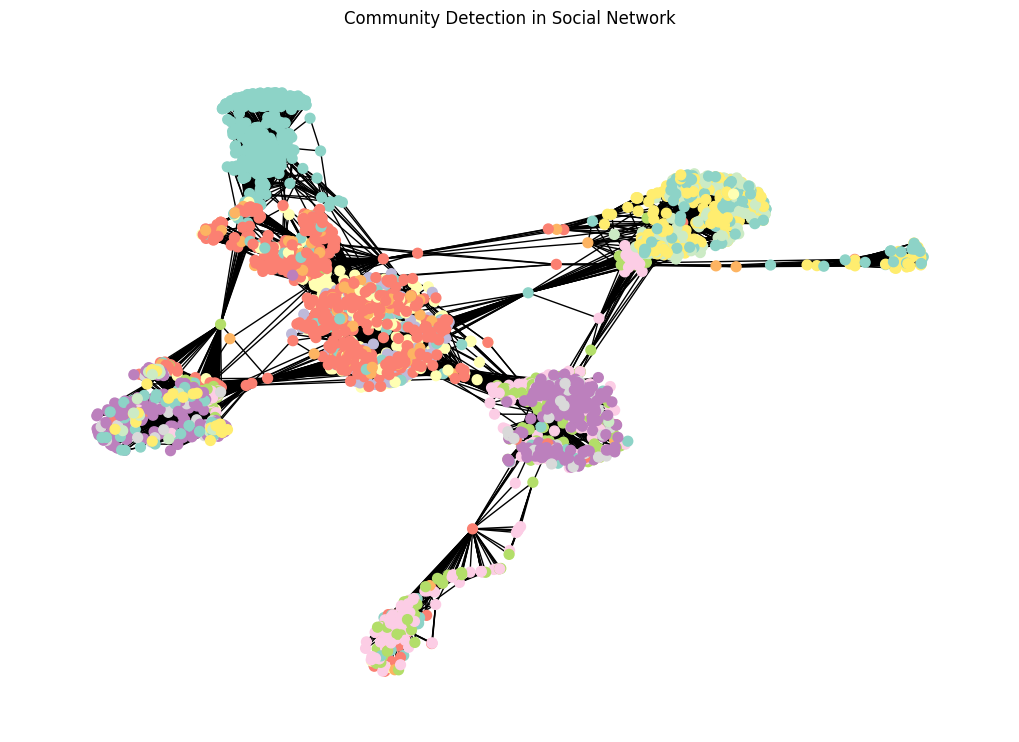

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assign Colors to Communities
color_map = [communities_pd.loc[communities_pd["id"] == n, "label"].values[0] if n in communities_pd["id"].values else 0 for n in node_ids]

plt.figure(figsize=(10, 7))
G = nx.from_pandas_edgelist(edges_pd, "src", "dst")
nx.draw(G, node_color=color_map, node_size=50, cmap=plt.cm.Set3, with_labels=False)
plt.title("Community Detection in Social Network")
plt.show()


In [ ]:
import pandas as pd

# Convert DataFrames to Pandas
pagerank_pd = pagerank.vertices.toPandas()
communities_pd = communities.toPandas()

# Merge PageRank Scores with Communities
community_ranks = communities_pd.merge(pagerank_pd, on="id")

# Find the Most Influential User in Each Community
top_influencers = (
    community_ranks.groupby("label")
    .apply(lambda x: x.nlargest(1, "pagerank"))
    .reset_index(drop=True)
)

print("Most Influential Users in Each Community:\n", top_influencers[["label", "id", "pagerank"]])


Most Influential Users in Each Community:
     label    id  pagerank
0      92   330  1.768796
1      95   319  1.598194
2     107  1499  0.915816
3     110   259  1.838808
4     137   312  2.623981
..    ...   ...       ...
86   3995  3987  0.317357
87   3998  4026  1.557340
88   4007  4016  0.580405
89   4016  4007  0.407283
90   4031  4006  0.317357

[91 rows x 3 columns]


<ipython-input-42-0d9df73715cd>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(1, "pagerank"))
